In [1]:
#https://github.com/pomber/covid19
print('Initializing world\'s analysis!')
import numpy as np
import pandas as pd
from fbprophet import Prophet

import matplotlib.pyplot as plt
import datetime

Initializing world's analysis!


In [2]:
df = pd.read_csv('../data/world_corona19_data.csv', sep=',')
df['date'] = df['date'].astype('datetime64[ns]')

today = str(df.date.max().date())
tomorrow = str(df.date.max().date() + datetime.timedelta(days=1))
dayAfterTomorrow = str(df.date.max().date() + datetime.timedelta(days=2))
yesterday = str(df.date.max().date() - datetime.timedelta(days=1))

df[df['country']=='Brazil'].tail()

,country,date,cases,deaths,recoveries,day,case_day,death_day,recovery_day,%var_case_day,...,recoveries_million,avg7_cases,avg7_deaths,avg7_recoveries,avg7_cases_million,avg7_deaths_million,avg7_recoveries_million,perc_death,perc_recovery,active_cases
1202,Brazil,2020-04-21,43079,2741,22991,56,2336,154,861,11.82,...,4.1,2545.0,172.0,2849.0,12.0,0.0,13.0,6.36,53.37,17347
1203,Brazil,2020-04-22,45757,2906,25318,57,2678,165,2327,14.64,...,11.0,2491.0,167.0,1613.0,11.0,0.0,7.0,6.35,55.33,17533
1204,Brazil,2020-04-23,50036,3331,26573,58,4279,425,1255,59.78,...,5.9,2801.0,201.0,1792.0,13.0,0.0,8.0,6.66,53.11,20132
1205,Brazil,2020-04-24,54043,3704,27655,59,4007,373,1082,-6.36,...,5.1,2908.0,223.0,1947.0,13.0,1.0,9.0,6.85,51.17,22684
1206,Brazil,2020-04-25,59324,4057,29160,60,5281,353,1505,31.79,...,7.1,3238.0,243.0,2162.0,15.0,1.0,10.0,6.84,49.15,26107


In [3]:
countries = df['country'].unique()
countries

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria',
       'Burkina Faso', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Diamond Princess', 'Cuba', 'Cyprus',
       'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador',
       'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala',
       'Guinea', 'Guyana', 'Haiti', 'Holy See', 'Honduras', 'Hungary',
       'Iceland', 'India

----------------------------
### Predicting cases and death for a selected country

#### selecting a country for prediction

In [4]:
#inform the countries for predictions
predictedCountries = ['Brazil','Italy', 'United Kingdom', 'Spain', 'US', 'Belgium', 'France']

,country,ds,case_day,death_day,cases,deaths,predicted?
88,France,2020-04-21,2775,537,158168,20829,False
89,France,2020-04-22,-2188,544,155980,21373,False
90,France,2020-04-23,2323,516,158303,21889,False
91,France,2020-04-24,1649,390,159952,22279,False
92,France,2020-04-25,1692,369,161644,22648,False
93,France,2020-04-26,6109,636,167753,23284,True
94,France,2020-04-27,4749,691,172502,23975,True
95,France,2020-04-28,4958,757,177460,24732,True
96,France,2020-04-29,4302,771,181762,25503,True
97,France,2020-04-30,5255,802,187017,26305,True


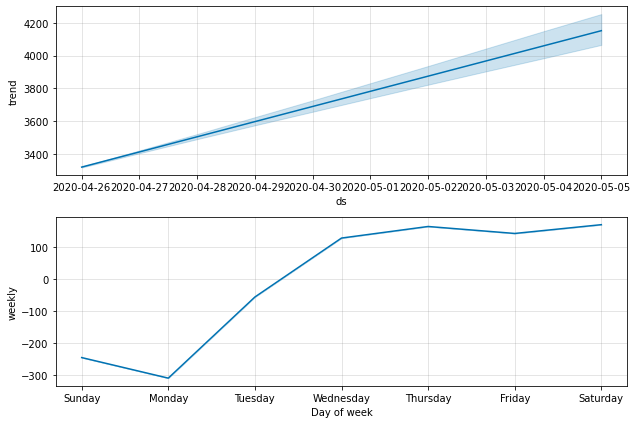

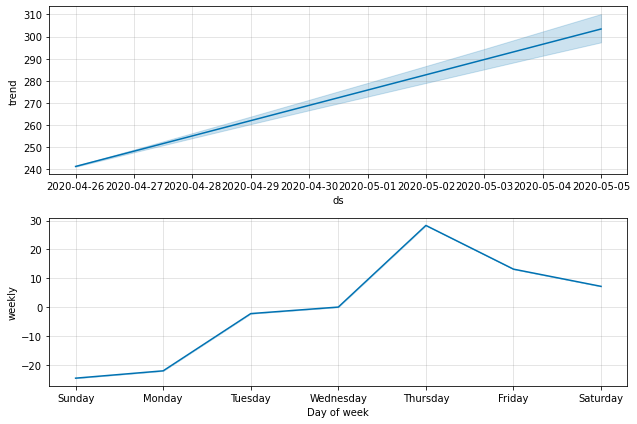

In [5]:
df_prediction = pd.DataFrame(columns=['country','ds', 'case_day', 'death_day', 'cases', 'deaths'])
daysToPredict = 10

for country in predictedCountries:
    # preparing dataset for predictions
    df_country = df.loc[df['country'] == country][['date','country','case_day','death_day']]
    df_country.rename(columns={'date': 'ds'}, inplace= True)
    df_cases = df_country.loc[:,['ds','case_day']]
    df_cases.rename(columns={'case_day':'y'}, inplace =True)

    df_deaths = df_country.loc[:,['ds','death_day']]
    df_deaths.rename(columns={'death_day':'y'}, inplace =True)
    
    # fiting the model and making prediction
    m_cases = Prophet(yearly_seasonality=False, daily_seasonality=False, interval_width=0.95, growth='linear')
    m_cases.fit(df_cases)
    m_deaths = Prophet(yearly_seasonality=False, daily_seasonality=False, interval_width=0.95, growth='linear')
    m_deaths.fit(df_deaths)
    
    future_cases = m_cases.make_future_dataframe(periods=daysToPredict, freq='D', include_history=False)
    future_deaths = m_deaths.make_future_dataframe(periods=daysToPredict, freq='D', include_history=False)
    
    forecast_cases = m_cases.predict(future_cases)
    forecast_deaths = m_deaths.predict(future_deaths)
    if country == 'Brazil':
        fig = m_cases.plot_components(forecast_cases)
        fig.savefig('../predictions/brazil_prophet_cases.png')
        fig = m_deaths.plot_components(forecast_deaths)
        fig.savefig('../predictions/brazil_prophet_deaths.png')
        
    p = forecast_cases.loc[:,['ds','yhat']]
    p.rename(columns={'yhat': 'y'}, inplace= True)
    t = df_cases.append(p[['ds','y']], ignore_index=True)
    
    p = forecast_deaths.loc[:,['ds','yhat']]
    p.rename(columns={'yhat': 'y'}, inplace= True)
    s = df_deaths.append(p[['ds','y']], ignore_index=True)

    t['ds'] = t['ds'].astype('datetime64[ns]')
    t.rename(columns={'y': 'case_day'}, inplace= True)
    t['case_day'] = t['case_day'].astype('int32')
    t['cases'] = t['case_day'].cumsum().astype('int32')
    t['death_day'] = s['y'].astype('int32')
    t['deaths'] = t['death_day'].cumsum().astype('int32')
    t['country'] = country
    t['predicted?'] = t['ds'] > today # para separar o que é previsão (True) do que é dado real (False)
    df_prediction = df_prediction.append(t)
    
df_prediction.to_csv('../predictions/worldPrediction_' + today + '.csv', index = False)
df_prediction.tail(15)

In [6]:
df_prediction.loc[df_prediction['ds']==tomorrow]

,country,ds,case_day,death_day,cases,deaths,predicted?
60,Brazil,2020-04-26,3073,216,62397,4273,True
86,Italy,2020-04-26,5223,725,200574,27109,True
86,United Kingdom,2020-04-26,6308,863,155877,21244,True
85,Spain,2020-04-26,6464,697,230223,23599,True
95,US,2020-04-26,36520,2633,974674,56388,True
82,Belgium,2020-04-26,1553,275,46878,7192,True
93,France,2020-04-26,6109,636,167753,23284,True


In [7]:
df_prediction.loc[df_prediction['ds']==dayAfterTomorrow]

,country,ds,case_day,death_day,cases,deaths,predicted?
61,Brazil,2020-04-27,3101,226,65498,4499,True
87,Italy,2020-04-27,4832,745,205406,27854,True
87,United Kingdom,2020-04-27,6078,843,161955,22087,True
86,Spain,2020-04-27,6341,708,236564,24307,True
96,US,2020-04-27,36934,2630,1011608,59018,True
83,Belgium,2020-04-27,1412,277,48290,7469,True
94,France,2020-04-27,4749,691,172502,23975,True


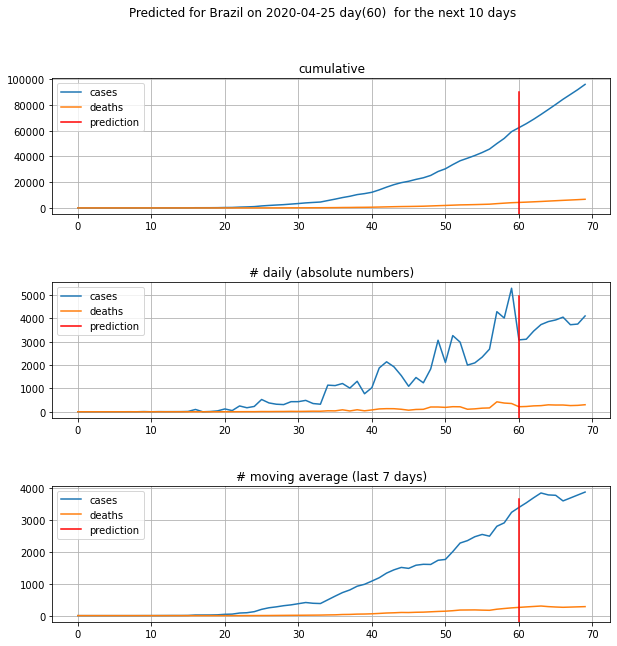

In [8]:
df_br = df_prediction.loc[df_prediction['country']=='Brazil']
df_br.reset_index(0, inplace=True)

x = df_br.index
corte = df_br.loc[df_br.ds == str(today)].index[0]+1

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10,10))
fig.suptitle('Predicted for ' + df_br.country[0] + ' on ' + today + ' day('+ str(corte) +') ' + ' for the next ' + str(daysToPredict) + ' days')
fig.subplots_adjust(hspace = 0.5)
ax1.set_title('cumulative')
ax1.plot(x, df_br['cases'], label = 'cases')#, linewidths = 0.01)
ax1.plot(x, df_br['deaths'], label = 'deaths')
ax1.grid()
ax1.axvline(x=corte, ymin=0, ymax=0.9, color = 'red', label = 'prediction')
ax1.legend()

ax2.set_title('# daily (absolute numbers)')
ax2.plot(x, df_br['case_day'], label = 'cases')
ax2.plot(x, df_br['death_day'], label = 'deaths')
ax2.grid()
ax2.axvline(x=corte, ymin=0, ymax=0.9, color = 'red', label = 'prediction')
ax2.legend()

avg7_cases_million = df_br['case_day'].rolling(window=7).mean().replace([np.inf, -np.inf], 0).replace([np.nan], 0).astype('int')
avg7_death_million = df_br['death_day'].rolling(window=7).mean().replace([np.inf, -np.inf], 0).replace([np.nan], 0).astype('int')

ax3.set_title('# moving average (last 7 days)')
ax3.plot(x, avg7_cases_million, label = 'cases')
ax3.plot(x, avg7_death_million, label = 'deaths')
ax3.grid()
ax3.axvline(x=corte, ymin=0, ymax=0.9, color = 'red', label = 'prediction')
ax3.legend()

plt.savefig('../predictions/brazil_predictions.png')

### Generating the markdown file

In [9]:
f = open('../predictions/README_WORLD.md', 'w')

readme = '# **Predições**\n'
readme += "Para experiência, estou fazendo predições simples sobre a quantidade de casos e mortes diárias. Como são séries temporais (*time-series*), estou usando [Facebook Prophet](https://facebook.github.io/prophet/docs/quick_start.html) que também é desenhado para este tipo de predição de uma maneira bem mais simples. "
readme += "Isso funciona muito bem na maioria das vezes; porém, algumas vezes há um grande salto entre os números que impactam no desempenho do modelo e leva um tempo (medições) para ser absorvido e compreendidos.\n\n"
readme += 'Essas predições foram feitas com os dados mundiais da pandemia Covid19 até **' + today + '**.\n\n'
readme += "Como há muitos paises para terem seus dados submetidos ao modelo de predição de uma só vez, selecionei alguns mais o Brasil:\n"
readme += str(predictedCountries) + '.\n'
readme += '***Dica**: você mesmo pode definir no notebook *[prediction.ipynb](../prediction.ipynb)* quais países você prefere fazer a predição.*\n\n\n'

readme += '## A predição\n'
readme += "As predições estão sendo realizadas sobre os dados diários de casos e de mortes."
readme += " Em seguida, os dados previstos são acumulados para que tenhamos a projeção acumulada. Estão sendo previstos os próximos " + str(daysToPredict) + " dias.\n"
readme += 'Ao ffim, é gerado o arquivo CSV contendo todas as previsões.\n\n'

readme += "#### Os últimos 5 dias da pandemia no Brasil e os próximos " + str(daysToPredict) + " dias previstos\n"
readme += "*predicted? = True* significa que são dados de predição; *=False* significa que são dados reais.\n"
readme += df_prediction[df_prediction['country']=='Brazil'].tail(15).to_markdown()

readme += "\n\n #### As curvas acumuladas previstas para o Brasil\n"
readme += '![](brazil_predictions.png)'

readme += "\n\n O Facebook Prophet gera automaticamente gráficos do comportamento sazonal dos dados, o que provê boas informações visuais. Aqui estão sobre as predições do Brasil:\n"
readme += "### Casos\n"
readme += '![](brazil_prophet_cases.png)\n\n '
readme += "### Mortes\n"
readme += '![](brazil_prophet_deaths.png)\n'

readme += "#### Finalmente, as predições para os países selecionados para:\n"
readme += '**Para amanhã**\n'
readme += df_prediction.loc[df_prediction['ds']==tomorrow].to_markdown()
readme += '\n\n **Para depois e amanhã** \n'
readme += df_prediction.loc[df_prediction['ds']==dayAfterTomorrow].to_markdown()

f.write(readme)
f.close()

f = open('../predictions/README_WORLD_EN.md', 'w')

readme = '# **Predictions**\n'
readme += "For experience, I'm running simple predictions over the cases and deaths per day. As they are time-series, I'm using [Facebook Prophet](https://facebook.github.io/prophet/docs/quick_start.html) that is also designed for this kind of prediction in a very simpler way. "
readme += "It works well for most of the time; sometimes there is a huge leap and it takes more time and more data to be understood.\n\n"
readme += 'These predictions were made with Covid19 pandemic data from **' + today + '**.\n\n'
readme += "As there are many countries to have their data predicted in a row, I selected a few of them plus Brazil to be predicted:\n"
readme += str(predictedCountries) + '.\n'
readme += '***Tip**: you can set yourself at the *[prediction.ipynb](../prediction.ipynb)* notebook which countries you prefer to predict*\n\n\n'

readme += '## The prediction\n'
readme += "As Facebook Prophet predicts time-series data and it is running the prediction over cases per day and deaths per day. After that, I compute theirs cumulatives.\
It is predicting for the next " + str(daysToPredict) + " days.\n"
readme += 'By the end, a CSV file containing all the predicted data is generated.\n\n'

readme += "#### The Brazil's last 5 days and next predicted " + str(daysToPredict) + " days\n"
readme += "*predicted? = True* means the line is a prediction; *=False* means they are real numbers.\n"
readme += df_prediction[df_prediction['country']=='Brazil'].tail(15).to_markdown()

readme += "\n\n #### The predicted Brazil's cumulative curves\n"
readme += '![](brazil_predictions.png)'

readme += "\n\nFacebook's Prophet automatically generates charts about the behaviour of the analysed and predicted data. That has a good visual information. Here are for the Brazil's prediction:\n"
readme += "### Cases\n"
readme += '![](brazil_prophet_cases.png)\n\n '
readme += "### Deaths\n"
readme += '![](brazil_prophet_deaths.png)\n'

readme += "#### Finally, the predictions for selected countries for:\n"
readme += '**Tomorrow**\n'
readme += df_prediction.loc[df_prediction['ds']==tomorrow].to_markdown()
readme += '\n\n **The day after tomorrow** \n'
readme += df_prediction.loc[df_prediction['ds']==dayAfterTomorrow].to_markdown()

f.write(readme)
f.close()
print('World\'s predictions done!')

World's predictions done!


In [10]:
# from fbprophet.diagnostics import cross_validation
# df_cv = cross_validation(m_cases, period='1 days', horizon = '10 days')
# df_cv.head()

# # Python
# from fbprophet.diagnostics import performance_metrics
# df_p = performance_metrics(df_cv)
# df_p.head()

In [11]:
# from fbprophet.diagnostics import performance_metrics
# df_p = performance_metrics(df_cv)
# df_p.head()